In [17]:
import tensorflow as tf
tf.config.list_physical_devices('GPU'),tf.config.list_physical_devices('CPU')

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')])

In [2]:
#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

In [18]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])

In [20]:
mode='VariableCone_m/'
#path='../PKL/Zprime'+mode+'singleBJet/'

path='../PKL/Zprime'+mode+'wrongscalingJet/'

In [21]:
#X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dp_f.retrieve_dataset(path)

OSError: ../PKL/ZprimeVariableCone_m/wrongscalingJet/X_train_scaled.csv not found.

In [23]:
X_train_scaled=np.genfromtxt(path+"X_train.csv",delimiter=',')
X_test_scaled=np.genfromtxt(path+"X_test.csv",delimiter=',')
y_train=np.genfromtxt(path+"y_train.csv",delimiter=',')
y_train_cat=np.genfromtxt(path+"y_train_cat.csv",delimiter=',')
y_test=np.genfromtxt(path+"y_test.csv",delimiter=',')
y_test_cat=np.genfromtxt(path+"y_test_cat.csv",delimiter=',')

In [24]:
n_c=32
device='gpu'

if device=='gpu':
    with tf.device("/gpu:0"):
        '''
        NN = models.Sequential()
#        NN.add(layers.Dense(3*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(64*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(64*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(32*n_c, activation=tf.nn.sigmoid))
        NN.add(layers.Dense(32*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(32*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(16*n_c, activation=tf.nn.sigmoid))
        NN.add(layers.Dense(16*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(16*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(8*n_c, activation=tf.nn.sigmoid))
        NN.add(layers.Dense(8*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(4*n_c, activation=tf.nn.relu))
        NN.add(layers.Dense(2*n_c, activation=tf.nn.sigmoid))
        NN.add(layers.Dense(2, activation=tf.nn.softmax, name='preds'))
        '''
        NN = models.Sequential()
        NN.add(layers.Dense(2*n_c, activation='relu'))
        NN.add(layers.Dense(2*n_c, activation='relu'))
        #NN.add(layers.Dense(n_c, activation='relu'))
        NN.add(layers.Dense(n_c, activation=tf.nn.sigmoid))
        NN.add(layers.Dense(2, activation='softmax', name='preds'))
        NN.compile(optimizer='adam',
                        loss='categorical_crossentropy',
#                        loss='binary_crossentropy',
                        metrics = ['accuracy'])

else:
    with tf.device("/cpu:0"):
        NN = models.Sequential()
        NN.add(layers.Dense(2*n_c, activation='relu'))
        NN.add(layers.Dense(2*n_c, activation='relu'))
        #NN.add(layers.Dense(n_c, activation='relu'))
        NN.add(layers.Dense(2, activation='softmax', name='preds'))

        NN.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        #metrics = ['accuracy'])
                        metrics = ['CategoricalCrossentropy'])


In [25]:
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 np.unique(y_train),
#                                                 y_train)

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train), 
                y_train))) 

class_weights

/home/salomongpu/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[0. 1. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0.0: 0.7320607303152878, 1.0: 1.5773042024832855}

In [26]:
#NN_model_name='NN_base_rew'
#NN=tf.keras.models.load_model(path+'models/'+NN_model_name)

Epoch 1/10
6606/6606 [==============================] - 29s 4ms/step - loss: 0.6610 - accuracy: 0.5886
Epoch 2/10
6606/6606 [==============================] - 31s 5ms/step - loss: 0.5949 - accuracy: 0.6716
Epoch 3/10
6606/6606 [==============================] - 29s 4ms/step - loss: 0.5864 - accuracy: 0.6783
Epoch 4/10
6606/6606 [==============================] - 29s 4ms/step - loss: 0.5834 - accuracy: 0.6808
Epoch 5/10
6606/6606 [==============================] - 28s 4ms/step - loss: 0.5651 - accuracy: 0.6972
Epoch 6/10
6606/6606 [==============================] - 33s 5ms/step - loss: 0.5375 - accuracy: 0.7107
Epoch 7/10
6606/6606 [==============================] - 25s 4ms/step - loss: 0.5094 - accuracy: 0.7303
Epoch 8/10
6606/6606 [==============================] - 26s 4ms/step - loss: 0.4947 - accuracy: 0.7398
Epoch 9/10
6606/6606 [==============================] - 30s 5ms/step - loss: 0.4939 - accuracy: 0.7326
Epoch 10/10
6606/6606 [==============================] - 31s 5ms/step - l

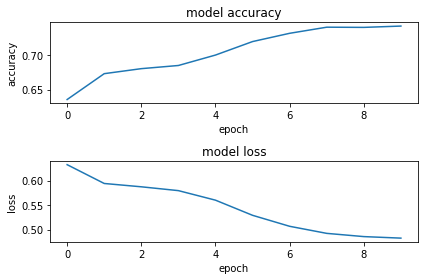

In [27]:
history=NN.fit(X_train_scaled, y_train_cat, class_weight=class_weights, batch_size=8, epochs=10, verbose=1)

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xscale('log')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xscale('log')

plt.tight_layout()
fig

print('accuracy:', history.history['accuracy'][-1], 'loss:', history.history['loss'][-1])

#print('Evaluation on training set')
#NN.evaluate(X_train_scaled, y_train_cat)
#print('Evaluation on test set')
#NN.evaluate(X_test_scaled, y_test_cat)


Epoch 1/40
13212/13212 [==============================] - 58s 4ms/step - loss: 0.4978 - accuracy: 0.7347
Epoch 2/40
13212/13212 [==============================] - 57s 4ms/step - loss: 0.4913 - accuracy: 0.7346
Epoch 3/40
13212/13212 [==============================] - 57s 4ms/step - loss: 0.4878 - accuracy: 0.7382
Epoch 4/40
13212/13212 [==============================] - 65s 5ms/step - loss: 0.4828 - accuracy: 0.7409
Epoch 5/40
13212/13212 [==============================] - 62s 5ms/step - loss: 0.4764 - accuracy: 0.7460
Epoch 6/40
13212/13212 [==============================] - 59s 4ms/step - loss: 0.4673 - accuracy: 0.7540
Epoch 7/40
13212/13212 [==============================] - 56s 4ms/step - loss: 0.4546 - accuracy: 0.7609
Epoch 8/40
13212/13212 [==============================] - 58s 4ms/step - loss: 0.4410 - accuracy: 0.7698
Epoch 9/40
13212/13212 [==============================] - 50s 4ms/step - loss: 0.4280 - accuracy: 0.7781
Epoch 10/40
13212/13212 [==============================

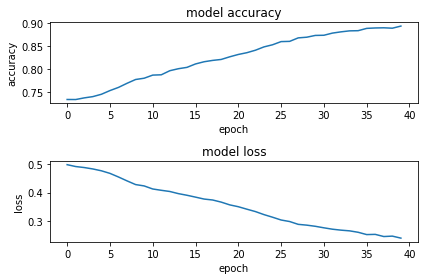

In [28]:
history=NN.fit(X_train_scaled, y_train_cat, class_weight=class_weights, batch_size=4, epochs=40, verbose=1)

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.xscale('log')
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.xscale('log')

plt.tight_layout()
fig

print('accuracy:', history.history['accuracy'][-1], 'loss:', history.history['loss'][-1])

#print('Evaluation on training set')
#NN.evaluate(X_train_scaled, y_train_cat)
#print('Evaluation on test set')
#NN.evaluate(X_test_scaled, y_test_cat)


In [29]:
print('Evaluation on test set 0')
NN.evaluate(X_test_scaled[y_test==0], y_test_cat[y_test==0])
print('Evaluation on test set 1')
NN.evaluate(X_test_scaled[y_test==1], y_test_cat[y_test==1])

Evaluation on test set 0
283/283 [==============================] - 0s 994us/step - loss: 0.2974 - accuracy: 0.8619
Evaluation on test set 1
131/131 [==============================] - 0s 3ms/step - loss: 0.4058 - accuracy: 0.8034


[0.4058116376399994, 0.8034003973007202]

In [30]:
model_name='NN_base'
NN.save(path+'models/'+model_name+'/')

INFO:tensorflow:Assets written to: ../PKL/ZprimeVariableCone_m/wrongscalingJet/models/NN_base/assets


INFO:tensorflow:Assets written to: ../PKL/ZprimeVariableCone_m/wrongscalingJet/models/NN_base/assets
